In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
plt.rcParams['figure.dpi'] = 120 # Adjusting figure size

In [2]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation

In [3]:
bit_file = 'bitcoin.csv'
ether_file = 'ethereum.csv'

In [4]:
def process(file):
    df = pd.read_csv(file, header=0)
    df['Time'] = pd.to_datetime(df['Date'])
    df.drop(columns=['Date'], inplace=True)
    columns = ['Open*','High','Low','Close**','Volume', 'Market Cap']
    df = df[['Time','Open*','High','Low','Volume', 'Market Cap','Close**']]
    
    for col in columns:
        df[col] = df[col].str.replace(',', '').astype(float)
        #df[col] = df[col].replace(astype(float))
    df = df.sort_values(by='Time').set_index('Time')
    return df

In [7]:
df = process(ether_file)
df = df[['Close**']]
train_df = df[:-100].copy()
test_df = df[-100:].copy()
train, test = train_df.values, test_df.values
    
train = np.reshape(train, (len(train), 1))
scale = MinMaxScaler()
train = scale.fit_transform(train)
x_train, y_train = train[0:len(train)-1], train[1:len(train)]
x_train = np.reshape(x_train, (len(x_train), 1, 1))
#df.plot(figsize=(15,5), title="Closing Price")    

In [8]:
model = Sequential()
model.add(LSTM(128,activation="sigmoid",input_shape=(1,1)))
model.add(Dropout(0.3)) # 0.2
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=100, batch_size=50)

Epoch 1/100
24/24 [==============================] - 0s 2ms/step - loss: 0.1003
Epoch 2/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0912
Epoch 3/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0842
Epoch 4/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0706
Epoch 5/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0739
Epoch 6/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0669
Epoch 7/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0666
Epoch 8/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0638
Epoch 9/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0549
Epoch 10/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0507
Epoch 11/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0483
Epoch 12/100
24/24 [==============================] - 0s 1ms/step - loss: 0.0426
Epoch 13/100
24/24 [=================

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [11]:
x_test = np.reshape(test, (len(test),1))
x_test = scale.transform(x_test)
x_test = np.reshape(x_test, (len(x_test),1,1))
y_pred = model.predict(x_test)
y_pred = scale.inverse_transform(y_pred)

In [12]:
test_df['Close_pred'] = y_pred
data = pd.concat([test_df, train_df], sort=False)

In [13]:
train_pred = model.predict(x_train)
train_pred = scale.inverse_transform(train_pred)

In [14]:
y_true = scale.inverse_transform(y_train)

<AxesSubplot:xlabel='Time'>

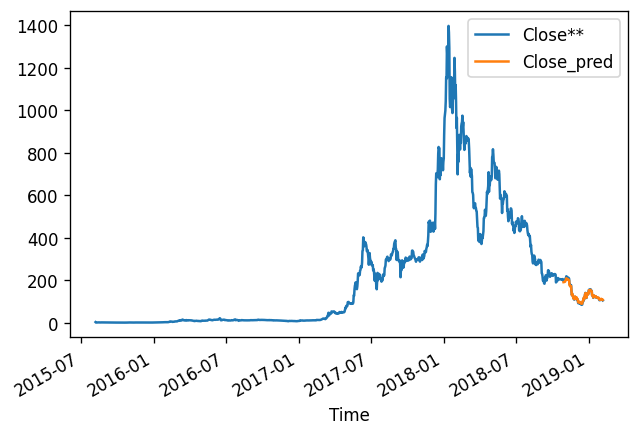

In [15]:
data.plot()

<AxesSubplot:xlabel='Time'>

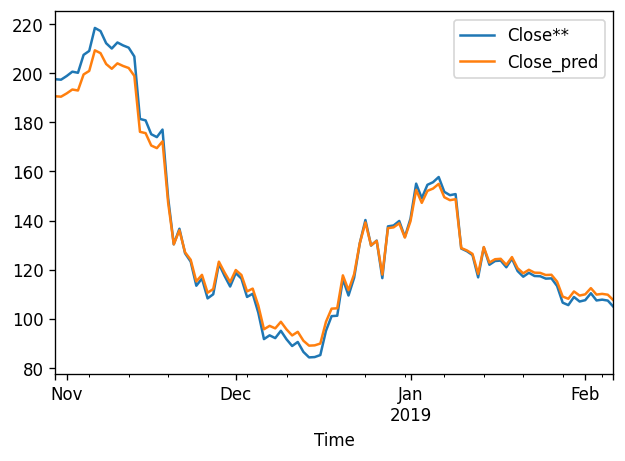

In [16]:
test_df.plot()

In [17]:
test_df['noise'] = np.random.normal(0, 10, len(test_df))

In [18]:
test_df['pred'] = test_df['Close_pred']+test_df['noise']

<AxesSubplot:xlabel='Time'>

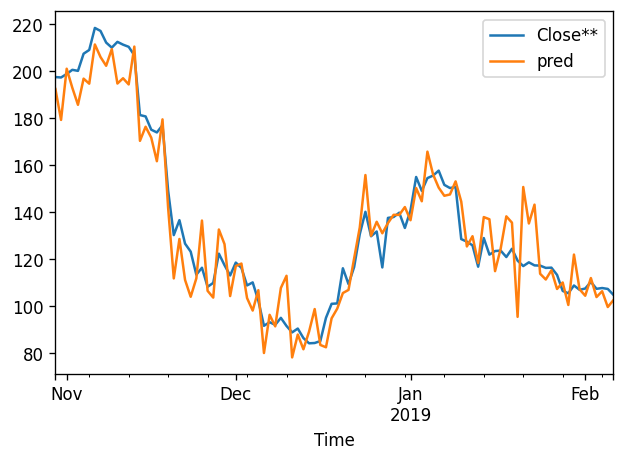

In [19]:
test_df[['Close**', 'pred']].plot()

In [20]:
test_df['rolling'] = test_df['pred'].rolling(window=5).mean()

<AxesSubplot:xlabel='Time'>

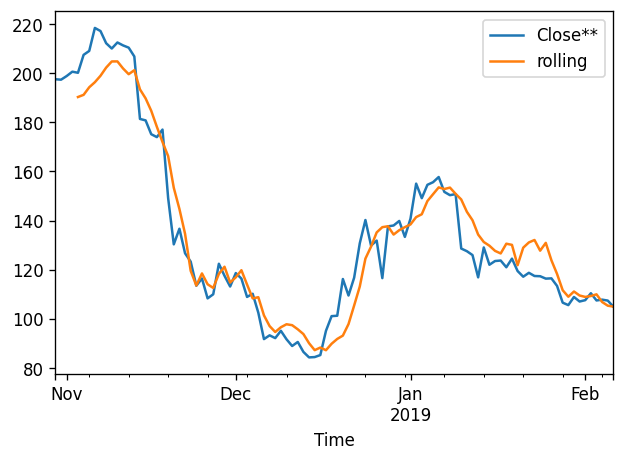

In [21]:
test_df[['Close**', 'rolling']].plot()

In [ ]:
plt.plot(test_df['Close**'], label="Actual Closing Value")
plt.plot(test_df['rolling'], label="Predicted Closing Value")
plt.title("Ethereum Closing Value")
plt.legend()
plt.savefig('ether_close.png')

In [25]:
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product

In [82]:
df = process(ether_file)
df = df[['Close**']]
train_df = df[:-100].copy()
test_df = df[-100:].copy()

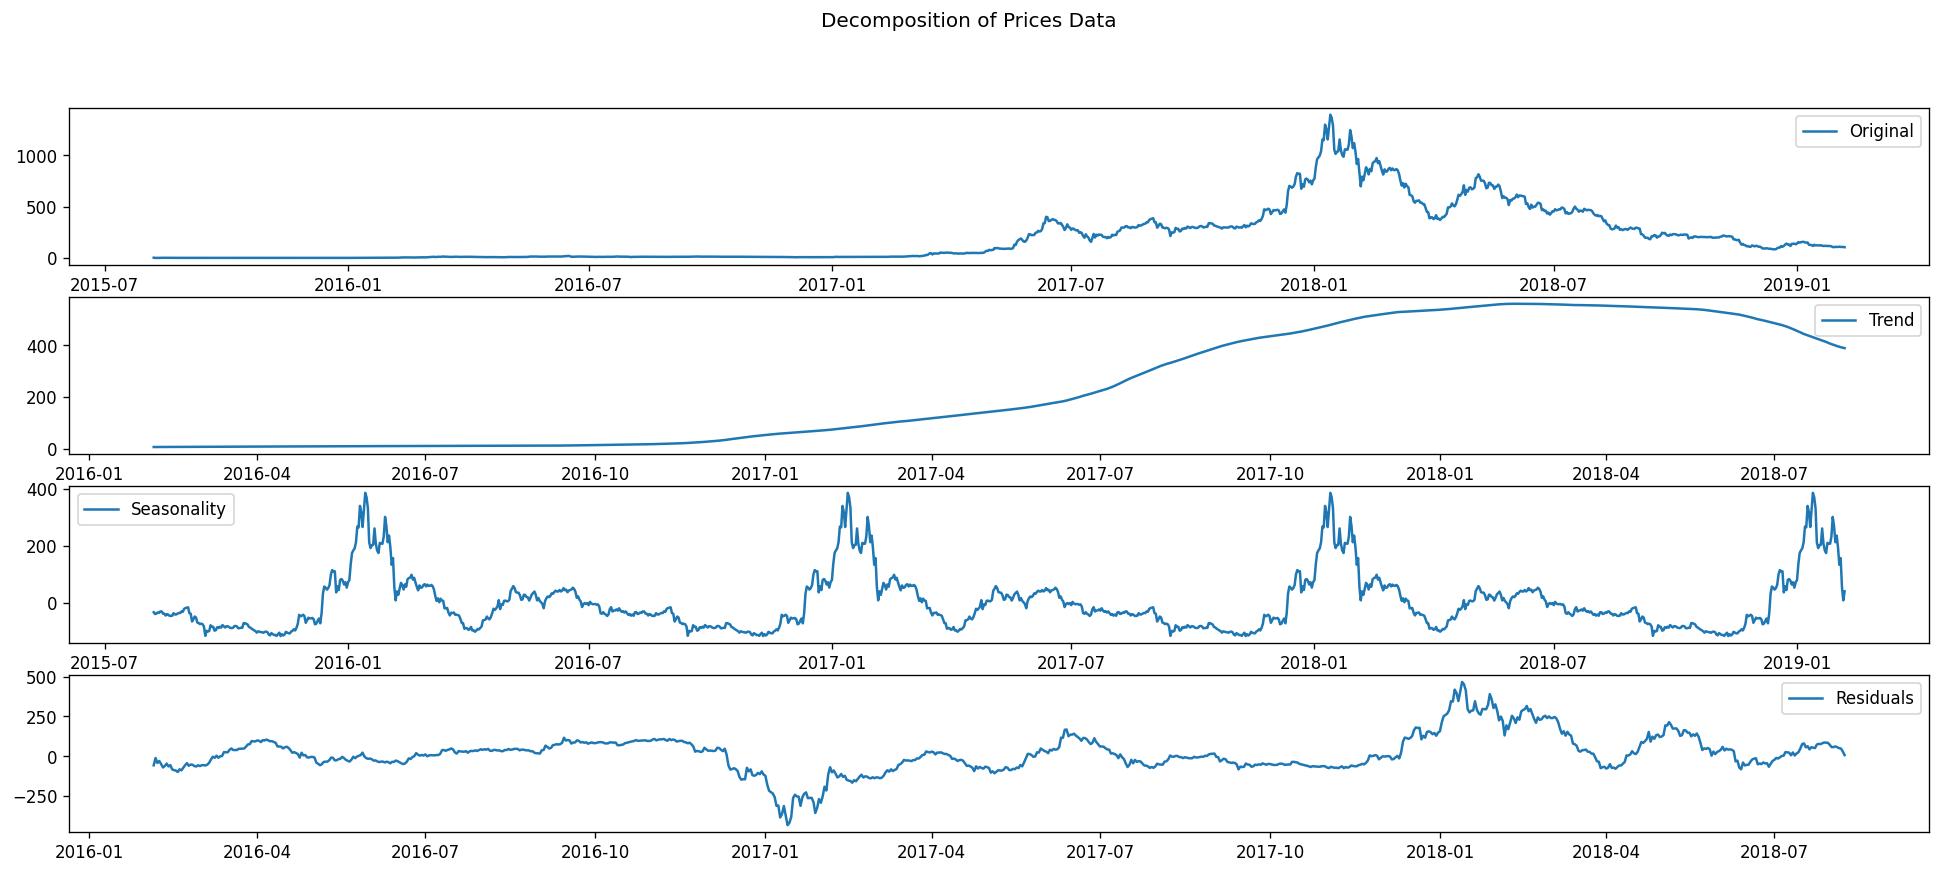

In [29]:
decomposition = sm.tsa.seasonal_decompose(df, period=365)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = plt.figure(figsize=(20,8))

plt.subplot(411)
plt.plot(df, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

fig.suptitle('Decomposition of Prices Data')
plt.show()

In [34]:
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df)[1])

Dickey–Fuller test: p=0.310661


In [37]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot

In [117]:
periods = 3
df_diff = df.diff(periods=periods)
df_diff.drop(df_diff.index[range(periods)], inplace=True)

periods = 3
train_df_diff = train_df.diff(periods=periods)
train_df_diff.drop(train_df_diff.index[range(periods)], inplace=True)

test_df_diff = test_df.diff(periods=periods)
test_df_diff.drop(test_df_diff.index[range(periods)], inplace=True)

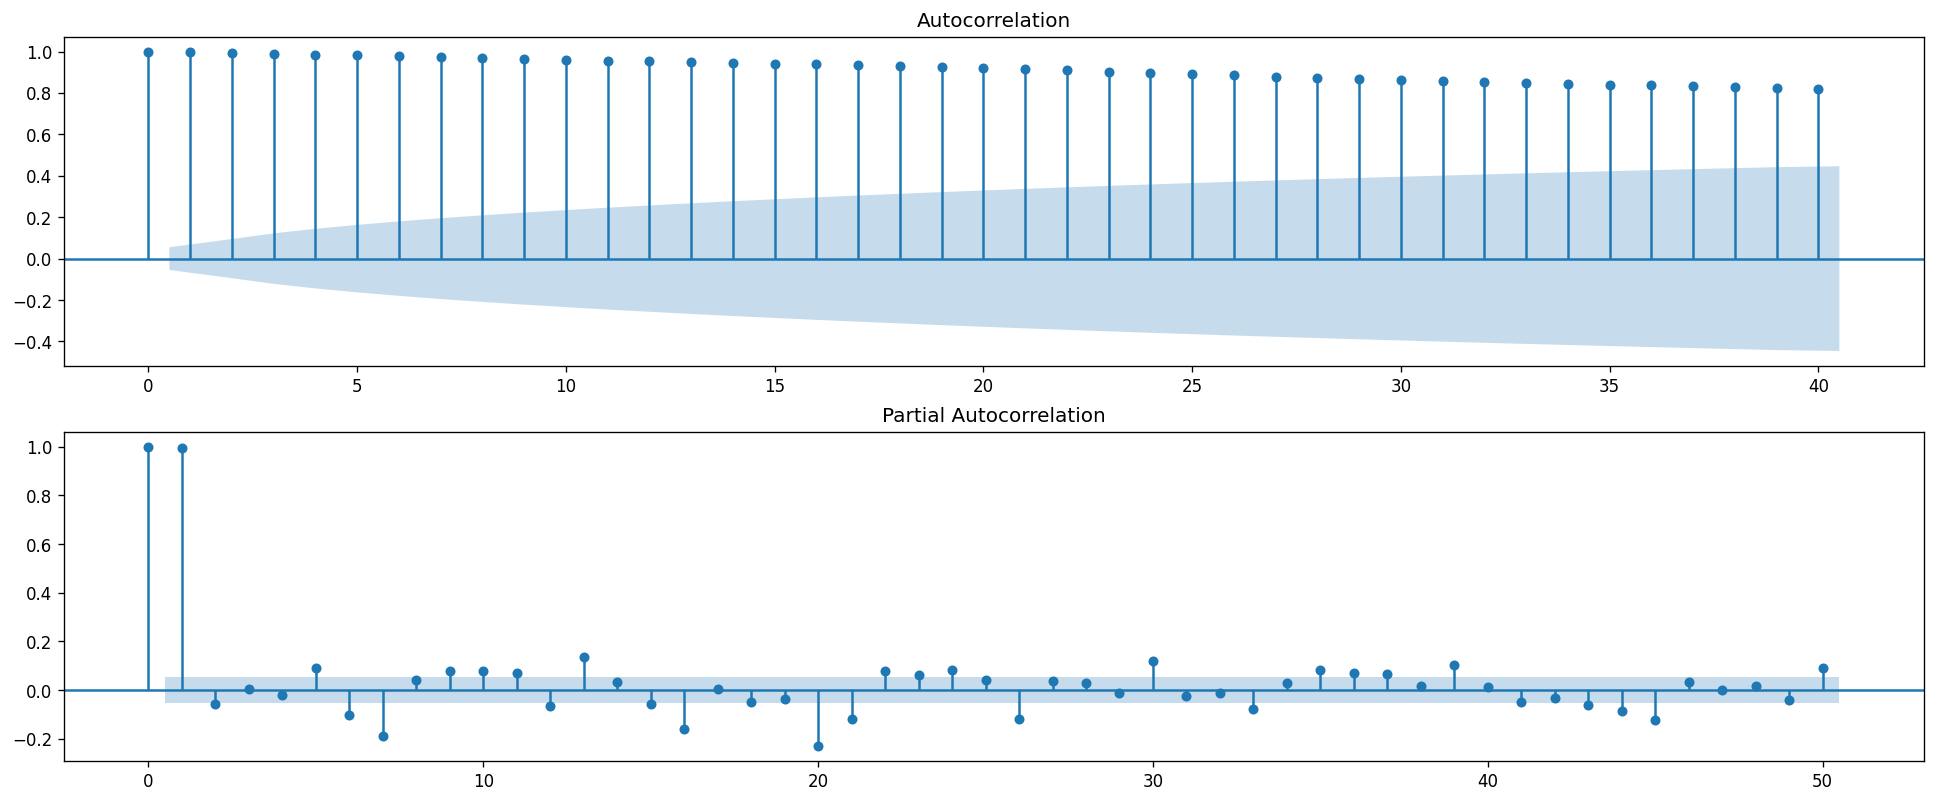

In [38]:
pyplot.figure(figsize=(20,8))
pyplot.subplot(211)
plot_acf(df, ax=pyplot.gca(),lags=40)
pyplot.subplot(212)
plot_pacf(df, ax=pyplot.gca(), lags=50)
pyplot.show()

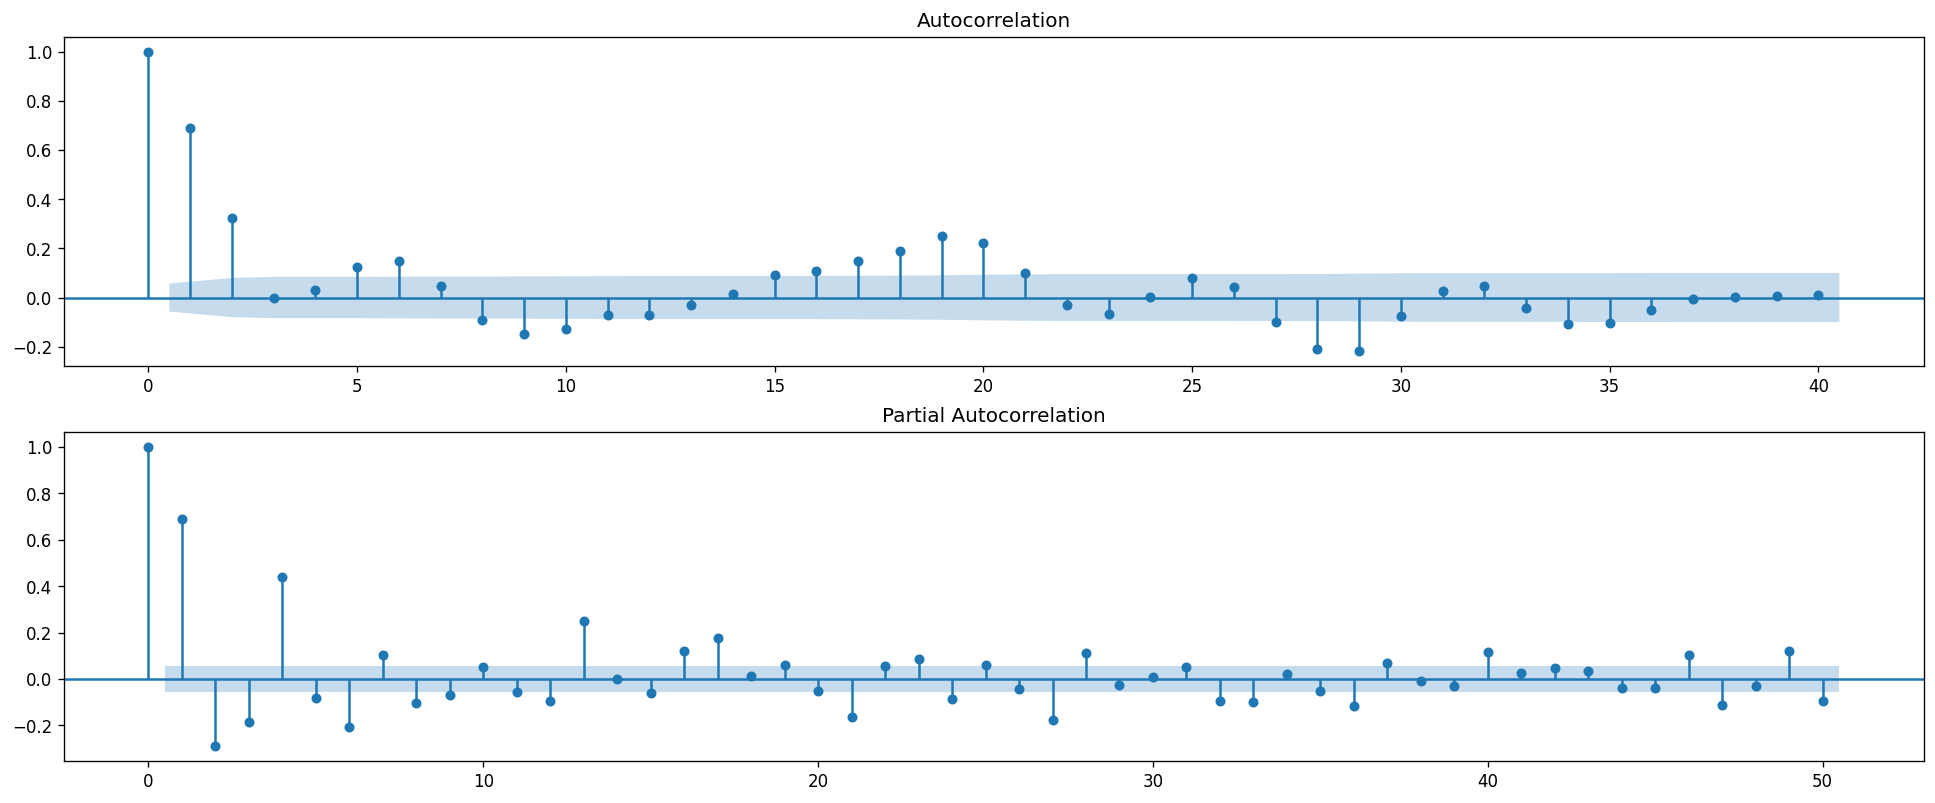

In [85]:
pyplot.figure(figsize=(20,8))
pyplot.subplot(211)
plot_acf(train_df_diff, ax=pyplot.gca(),lags=40)
pyplot.subplot(212)
plot_pacf(train_df_diff, ax=pyplot.gca(), lags=50)
pyplot.show()

In [122]:
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(train_df, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12),enforce_stationarity=False,
                                            enforce_invertibility=False).fit(disp=-1)
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [140]:
results

[[(0, 0, 0, 0), 11498.193601365028],
 [(0, 0, 0, 1), 10553.197272717403],
 [(0, 0, 1, 0), 11057.922587248142],
 [(0, 0, 1, 1), 10553.737609134365],
 [(0, 0, 2, 0), 10779.266463836637],
 [(0, 0, 2, 1), 10460.080080925443],
 [(0, 1, 0, 0), 11490.274732844902],
 [(0, 1, 0, 1), 10544.443853986422],
 [(0, 1, 1, 0), 11059.489992485136],
 [(0, 1, 1, 1), 10544.482325642788],
 [(0, 1, 2, 0), 10778.60987058015],
 [(0, 1, 2, 1), 10458.98472756394],
 [(0, 2, 0, 0), 11482.451197336271],
 [(0, 2, 0, 1), 10538.278771219944],
 [(0, 2, 1, 0), 11061.449386391461],
 [(0, 2, 1, 1), 10537.777420455448],
 [(0, 2, 2, 0), 10779.924959123378],
 [(0, 2, 2, 1), 10460.86861198844],
 [(1, 0, 0, 0), 11499.076158489912],
 [(1, 0, 0, 1), 10552.80722495824],
 [(1, 0, 1, 0), 11050.922143671163],
 [(1, 0, 1, 1), 10553.043059845331],
 [(1, 0, 2, 0), 10770.066696541513],
 [(1, 0, 2, 1), 10450.49504167775],
 [(1, 1, 0, 0), 11491.614344148176],
 [(1, 1, 0, 1), 10542.955097036189],
 [(1, 1, 1, 0), 11052.947758969356],
 [(1, 

Text(0.5, 0.98, 'Residual Plot of the Best Model')

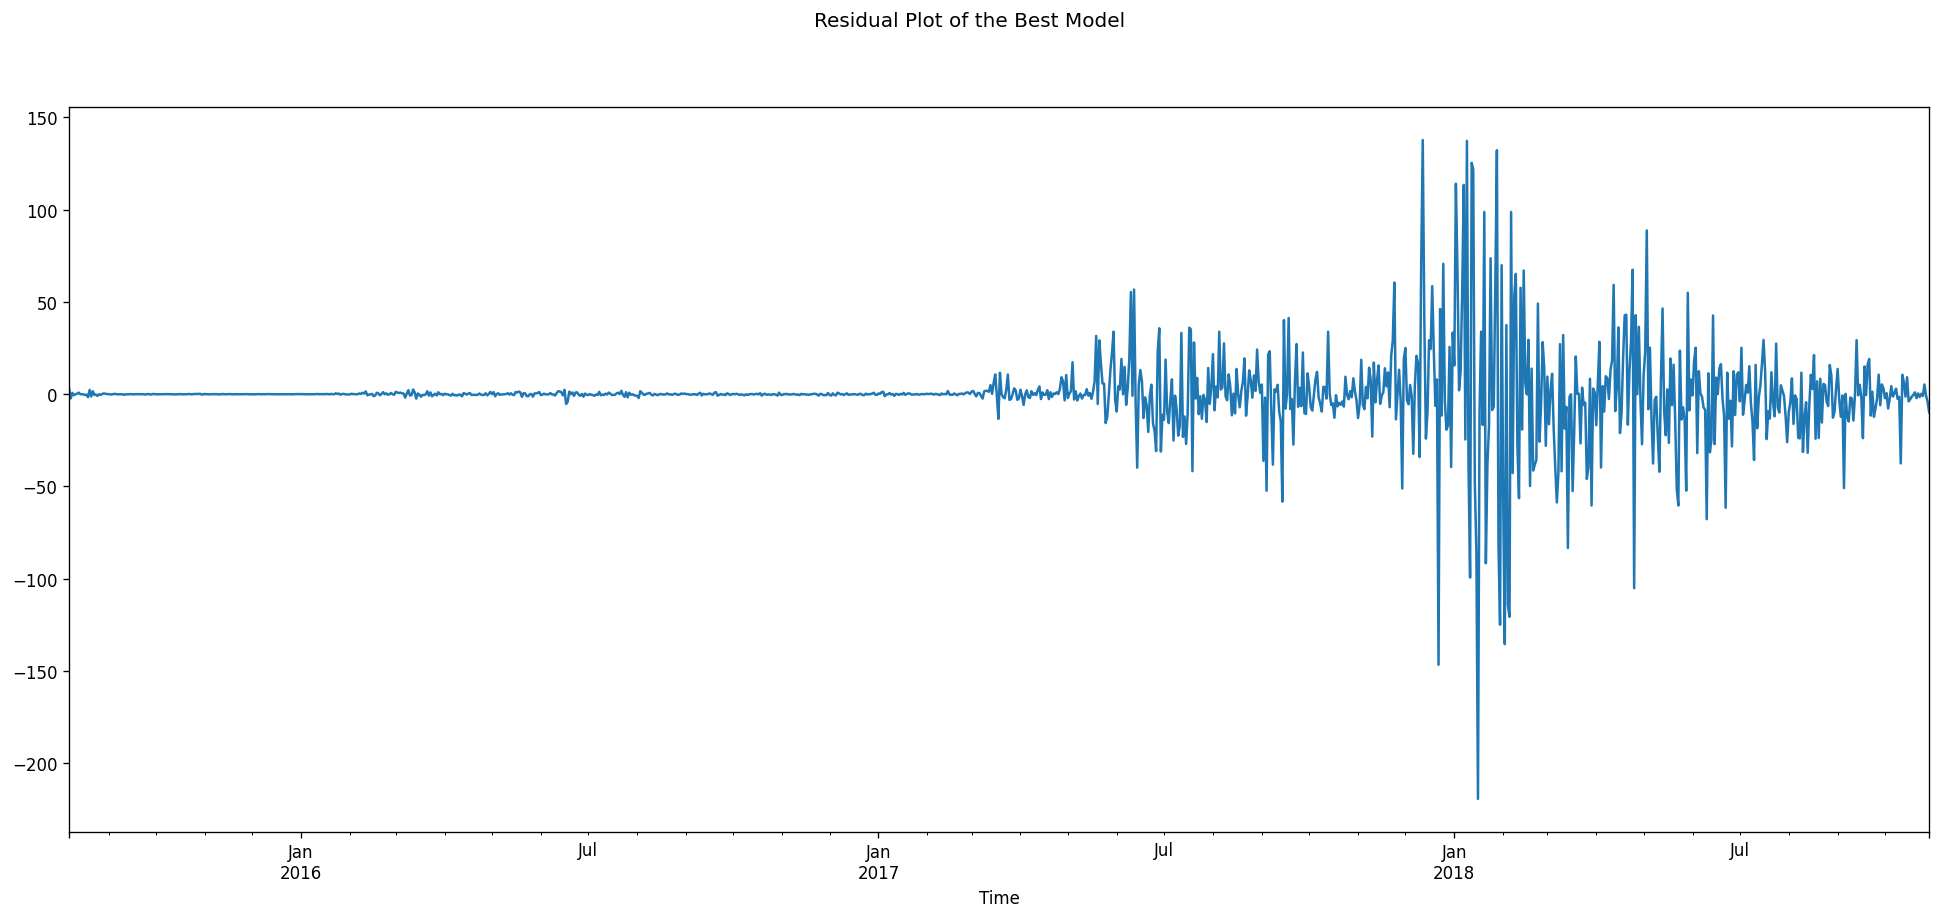

In [124]:
fig = plt.figure(figsize=(20,8))
best_model.resid.plot()
fig.suptitle('Residual Plot of the Best Model')
#print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid)[1])

In [125]:
#best_model.resid = best_model.resid[periods:,]
print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid)[1])

Dickey–Fuller test:: p=0.000000


In [96]:
x_test = np.reshape(test, (len(test),1))
x_test = scale.transform(x_test)
x_test = np.reshape(x_test, (len(x_test),1,1))
# y_pred = model.predict(x_test)
# y_pred = scale.inverse_transform(y_pred)

In [156]:
df_month2 = test_df
future = pd.DataFrame()
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = best_model.predict(start=1177, end=1279)

In [160]:
df_month2[1:10]

,Close**,forecast
Time,,
2018-10-31,197.38,192.230883
2018-11-01,198.87,193.016716
2018-11-02,200.64,196.704233
2018-11-03,200.19,195.323094
2018-11-04,207.49,195.808712
2018-11-05,209.09,194.855377
2018-11-06,218.45,195.467039
2018-11-07,217.18,191.190534
2018-11-08,212.23,192.198253


<AxesSubplot:xlabel='Time'>

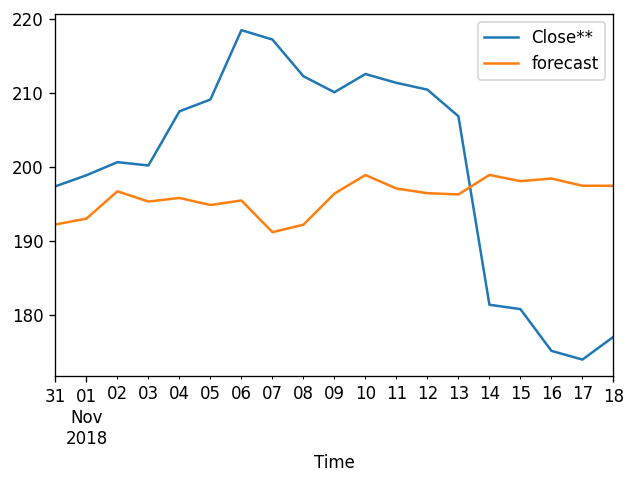

In [162]:
df_month2[1:20][['Close**','forecast']].plot()

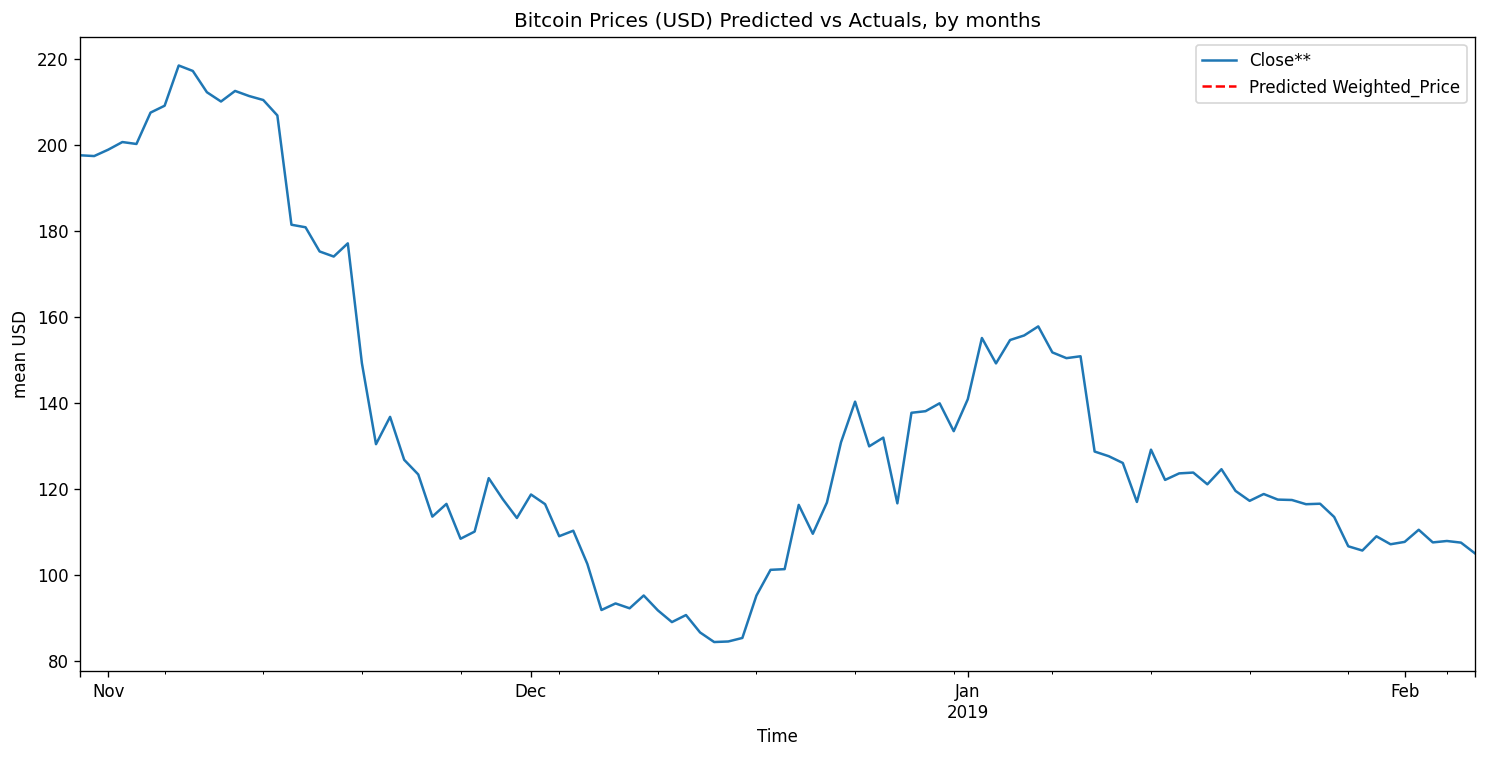

In [147]:
df_month2 = test_df
future = pd.DataFrame()
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = best_model.predict(start=0, end=100)
plt.figure(figsize=(15,7))
df_month2['Close**'].plot()
df_month2['forecast'].plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title('Bitcoin Prices (USD) Predicted vs Actuals, by months')
plt.ylabel('mean USD')
plt.show()